In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table
import warnings

# Suppress warnings from LightGBM
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
from pandas.plotting import table

def save_dataframe_as_image(df, filename, width=12, height=8):
    """
    Save a DataFrame as an image file.
    """
    # Adjust the figsize to better accommodate the DataFrame
    fig, ax = plt.subplots(figsize=(width, height))  
    ax.axis('tight')
    ax.axis('off')

    # Improve table formatting
    tbl = table(ax, df, loc='center', cellLoc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)  # Adjust font size here
    tbl.scale(1.2, 1.2)  # Scale table size

    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)


In [3]:
# # Load preprocessed data
# y1_in_sample_filtered = pd.read_pickle('Datasave/Q1_filtered_0.35.pkl')

# # Prepare feature and target datasets
# X_y1 = y1_in_sample_filtered.drop(columns=['Y1', 'Q1', 'sym', 'exch'])
# y_y1 = y1_in_sample_filtered['Y1']
# y2_in_sample_filtered = pd.read_pickle('Datasave/Q2_filtered_0.35.pkl')
# X_y2 = y2_in_sample_filtered.drop(columns=['Y2', 'Q2', 'sym','exch']).iloc[:,1:40]
# y_y2 = y2_in_sample_filtered['Y2']


In [4]:
def load_and_prepare_data(filepath, drop_columns, target_column):
    """
    Loads data from a file and prepares it for modeling.
    Args:
    filepath (str): Path to the data file.
    drop_columns (list): List of columns to drop.
    target_column (str): Column name of the target variable.
    Returns:
    Tuple of DataFrame, features DataFrame, and target Series.
    """
    data = pd.read_pickle(filepath)
    display(data)
    X = data.drop(columns=drop_columns)
    y = data[target_column]
    return data, X, y

# Load data and prepare datasets
data, X_y1, y_y1 = load_and_prepare_data('Datasave/Q1_filtered2_0.6.pkl', ['Y1', 'Q1', 'sym', 'exch','time', 'date'], 'Y1')
display(X_y1)


,time,sym,exch,date,Y1,Q1,X1,X10,X100,X101,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:45:01,09:45:01,SPX,cme,2022-01-03,-4.967191e+01,1.00,-1.985130,-0.440099,0.044736,-0.010772,...,0.036888,0.020226,-0.496673,-0.419372,-2.094251,-0.544180,0.947544,-2.114019,-0.783769,-0.229752
2022-01-03 09:45:02,09:45:02,SPX,cme,2022-01-03,-4.889528e+01,1.00,-0.933646,-0.380986,-0.854499,-0.951011,...,-0.852265,-0.910145,-0.657351,-0.689837,-2.004462,-1.462824,-0.014917,-2.296994,-1.078146,-0.137521
2022-01-03 09:45:03,09:45:03,SPX,cme,2022-01-03,-4.706744e+01,1.00,-0.579249,-0.180915,-0.854372,-0.969687,...,-0.842401,-0.919075,-0.350017,-0.383252,-1.690756,-1.482096,-0.056237,-2.001233,-0.784774,0.171525
2022-01-03 09:45:04,09:45:04,SPX,cme,2022-01-03,-4.759041e+01,1.00,-0.658292,-0.028344,-0.044026,-0.496256,...,-0.031957,-0.441668,-0.085383,0.085024,-1.307463,-0.672521,0.405438,-1.738940,-0.313380,0.541654
2022-01-03 09:45:05,09:45:05,SPX,cme,2022-01-03,-4.811086e+01,1.00,-1.331419,-0.100419,0.273158,0.218558,...,0.281678,0.268776,0.342332,0.306470,-1.260183,-0.348818,1.124927,-1.298653,-0.081095,0.575009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 15:59:56,15:59:56,SPX,cme,2023-02-28,-8.803647e+00,0.21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28 15:59:57,15:59:57,SPX,cme,2023-02-28,-8.175329e+00,0.21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28 15:59:58,15:59:58,SPX,cme,2023-02-28,-5.661267e+00,1.00,-1.213168,-1.136721,NaN,-0.878878,...,NaN,-0.866625,-1.709110,-1.746943,-1.751714,NaN,-0.377860,-1.943471,-1.894090,-1.764978


,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:45:01,-1.985130,-0.440099,0.044736,-0.010772,-0.453612,-0.372317,-0.267032,-0.358980,0.223038,-0.682064,...,0.036888,0.020226,-0.496673,-0.419372,-2.094251,-0.544180,0.947544,-2.114019,-0.783769,-0.229752
2022-01-03 09:45:02,-0.933646,-0.380986,-0.854499,-0.951011,-0.622912,-0.651872,-0.177605,-1.275239,-0.737723,-0.863926,...,-0.852265,-0.910145,-0.657351,-0.689837,-2.004462,-1.462824,-0.014917,-2.296994,-1.078146,-0.137521
2022-01-03 09:45:03,-0.579249,-0.180915,-0.854372,-0.969687,-0.320432,-0.350608,0.135138,-1.292093,-0.777266,-0.567622,...,-0.842401,-0.919075,-0.350017,-0.383252,-1.690756,-1.482096,-0.056237,-2.001233,-0.784774,0.171525
2022-01-03 09:45:04,-0.658292,-0.028344,-0.044026,-0.496256,-0.057465,0.117910,0.516732,-0.481662,-0.314707,-0.305293,...,-0.031957,-0.441668,-0.085383,0.085024,-1.307463,-0.672521,0.405438,-1.738940,-0.313380,0.541654
2022-01-03 09:45:05,-1.331419,-0.100419,0.273158,0.218558,0.373589,0.342166,0.562226,-0.157728,0.404281,0.134184,...,0.281678,0.268776,0.342332,0.306470,-1.260183,-0.348818,1.124927,-1.298653,-0.081095,0.575009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 15:59:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28 15:59:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28 15:59:58,-1.213168,-1.136721,NaN,-0.878878,-1.743618,-1.945993,-1.879111,NaN,-0.615870,-1.960456,...,NaN,-0.866625,-1.709110,-1.746943,-1.751714,NaN,-0.377860,-1.943471,-1.894090,-1.764978


In [5]:
# Function to train the LightGBM model and calculate feature importances
def train_model(X, y, random_states, early_stopping_rounds):
    """
    Trains a LightGBM model and calculates feature importances.
    Args:
    X (DataFrame): Features DataFrame.
    y (Series): Target variable.
    random_states (list): List of random states for train-test splitting.
    early_stopping_rounds (int): Number of rounds for early stopping.
    Returns:
    DataFrame of feature importances and trained model.
    """
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns
    early_stop = False
    for i in random_states:
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=i)
        model = lgb.LGBMRegressor(num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100,
                                  min_data_in_leaf=20, feature_fraction=0.8, bagging_fraction=0.8,
                                  bagging_freq=5, reg_lambda=0.1, reg_alpha=0.1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[early_stopping(early_stopping_rounds)])
        feature_importances[f'importance_{i}'] = model.feature_importances_
        # Check if early stopping occurred
        if model.best_iteration_ < model.n_estimators:
            print(f'Early stopping occurred at iteration {model.best_iteration_}')
            early_stop = True
    if not early_stop:
        print('Model trained without early stopping.')
    return feature_importances, model

# # Train the model and get feature importances
# feature_importances, model = train_model(X_y1, y_y1, [0, 1], 100)


In [6]:
# Plotting 30 most important features and cumulative importance
def plot_feature_importances(df, threshold, y_suffix):
    # Sort the dataframe
    df = df.sort_values('average_importance', ascending=False).reset_index(drop=True)
    # Normalize the importance data
    df['importance_normalized'] = df['average_importance'] / df['average_importance'].sum()
    # Calculate the cumulative importance
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Create a line plot for the cumulative importance
    plt.figure(figsize=(24, 6))
    plt.plot(df['feature'], df['cumulative_importance'])

    # Customize the plot to achieve the desired aesthetics
    plt.xlabel('Feature', fontsize=12)
    plt.ylabel('Cumulative Importance', fontsize=12)
    plt.title(f'Cumulative Importance of Features for Y{y_suffix}', fontsize=12)

    # Find the feature at the threshold
    threshold_value = df[df['cumulative_importance'] >= threshold].iloc[0]

    # Draw a line for the threshold
    plt.axhline(y=threshold, color='navy', linestyle='--', lw=2, label=f'{threshold*100}% threshold')
    plt.axvline(x=threshold_value.name, color='green', linestyle='--', lw=2, label=f'Threshold feature: {threshold_value["feature"]}')
    
    plt.legend()

    # Customize the plot ticks and labels for a more minimalist design
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.grid(True)

    # Set tight layout to ensure everything fits without overlapping
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'Plot n result save/Cumulative_importance_{y_suffix}.png')

    # Show the plot
    plt.show()

    # Return the features to keep (up to the 95% importance threshold)
    features_to_keep = df[df['cumulative_importance'] <= threshold]['feature'].tolist()
    return df, features_to_keep


# plot_feature_importances(feature_importances, 0.95, 'Y1')

In [7]:
# # Filter out only the columns with numeric feature importance values before calculating the mean
# importance_columns = [col for col in feature_importances.columns if col.startswith('importance_')]
# feature_importances['average_importance'] = feature_importances[importance_columns].mean(axis=1)
# display(feature_importances.sort_values('average_importance', ascending=False).head(20))
# save_dataframe_as_image(feature_importances.sort_values('average_importance', ascending=False).head(20), 'Plot n result save/average_importance.png')


In [8]:
# display(all_features.head(30))
# save_dataframe_as_image(all_features.head(30), 'Plot n result save/feature_importance.png')


In [9]:
# Function to plot residuals and prediction error
def plot_residuals(y_true, y_pred):
    """
    Plots residuals and prediction error.
    Args:
    y_true (Series): Actual values of the target variable.
    y_pred (array): Predicted values.
    """
    residuals = y_true - y_pred

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'm--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Prediction Error Plot')
    plt.show()

# # Model evaluation
# # Split data for model evaluation
# X_train, X_val, y_train, y_val = train_test_split(X_y1, y_y1, test_size=0.2, random_state=42)

# y_pred = model.predict(X_val)
# plot_residuals(y_val, y_pred)


In [10]:
# # Plot validation curve
# eval_results = model.evals_result_
# sns.lineplot(x=range(1, len(eval_results['valid_0']['l2']) + 1), y=eval_results['valid_0']['l2'])
# plt.title('Validation Curve')
# plt.xlabel('Iteration')
# plt.ylabel('L2 Loss')
# plt.show()

In [11]:
# # Print zero importance features
# # Identify zero importance features based on the 'average_importance' column
# zero_importance_features = feature_importances[feature_importances['average_importance'] == 0]['feature'].tolist()
# print("Removed Zero Importance Features:", zero_importance_features)

# # Print evaluation results
# print("Evaluation Results:", eval_results)

# # Calculate and print RMSE
# rmse = math.sqrt(mean_squared_error(y_val, y_pred))
# print(f"Validation RMSE: {rmse}")

# # Calculate and print model scores
# train_score = model.score(X_train, y_train)
# val_score = model.score(X_val, y_val)
# print(f"Training Score: {train_score}")
# print(f"Validation Score: {val_score}")

In [12]:
# print(len(zero_importance_features))
# # Drop zero importance features from X_y1
# X_y1_reduced = X_y1.drop(columns=zero_importance_features)

# # Save the remaining column names to a CSV file
# remaining_features = X_y1_reduced.columns.tolist()
# remaining_features_df = pd.DataFrame(remaining_features, columns=['Feature'])
# remaining_features_df.to_pickle('Datasave/Q1_remaining_features.pkl')

Y1:


,time,sym,exch,date,Y1,Q1,X1,X10,X100,X101,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:45:01,09:45:01,SPX,cme,2022-01-03,-4.967191e+01,1.00,-1.985130,-0.440099,0.044736,-0.010772,...,0.036888,0.020226,-0.496673,-0.419372,-2.094251,-0.544180,0.947544,-2.114019,-0.783769,-0.229752
2022-01-03 09:45:02,09:45:02,SPX,cme,2022-01-03,-4.889528e+01,1.00,-0.933646,-0.380986,-0.854499,-0.951011,...,-0.852265,-0.910145,-0.657351,-0.689837,-2.004462,-1.462824,-0.014917,-2.296994,-1.078146,-0.137521
2022-01-03 09:45:03,09:45:03,SPX,cme,2022-01-03,-4.706744e+01,1.00,-0.579249,-0.180915,-0.854372,-0.969687,...,-0.842401,-0.919075,-0.350017,-0.383252,-1.690756,-1.482096,-0.056237,-2.001233,-0.784774,0.171525
2022-01-03 09:45:04,09:45:04,SPX,cme,2022-01-03,-4.759041e+01,1.00,-0.658292,-0.028344,-0.044026,-0.496256,...,-0.031957,-0.441668,-0.085383,0.085024,-1.307463,-0.672521,0.405438,-1.738940,-0.313380,0.541654
2022-01-03 09:45:05,09:45:05,SPX,cme,2022-01-03,-4.811086e+01,1.00,-1.331419,-0.100419,0.273158,0.218558,...,0.281678,0.268776,0.342332,0.306470,-1.260183,-0.348818,1.124927,-1.298653,-0.081095,0.575009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 15:59:56,15:59:56,SPX,cme,2023-02-28,-8.803647e+00,0.21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28 15:59:57,15:59:57,SPX,cme,2023-02-28,-8.175329e+00,0.21,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28 15:59:58,15:59:58,SPX,cme,2023-02-28,-5.661267e+00,1.00,-1.213168,-1.136721,NaN,-0.878878,...,NaN,-0.866625,-1.709110,-1.746943,-1.751714,NaN,-0.377860,-1.943471,-1.894090,-1.764978


Python(40427) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

,feature,importance_0,importance_1,average_importance
184,X50,165,159,162.0
186,X52,142,145,143.5
182,X49,144,141,142.5
172,X372,143,129,136.0
185,X51,132,134,133.0
187,X53,135,129,132.0
125,X232,123,122,122.5
126,X233,110,106,108.0
23,X121,86,93,89.5
22,X120,100,78,89.0


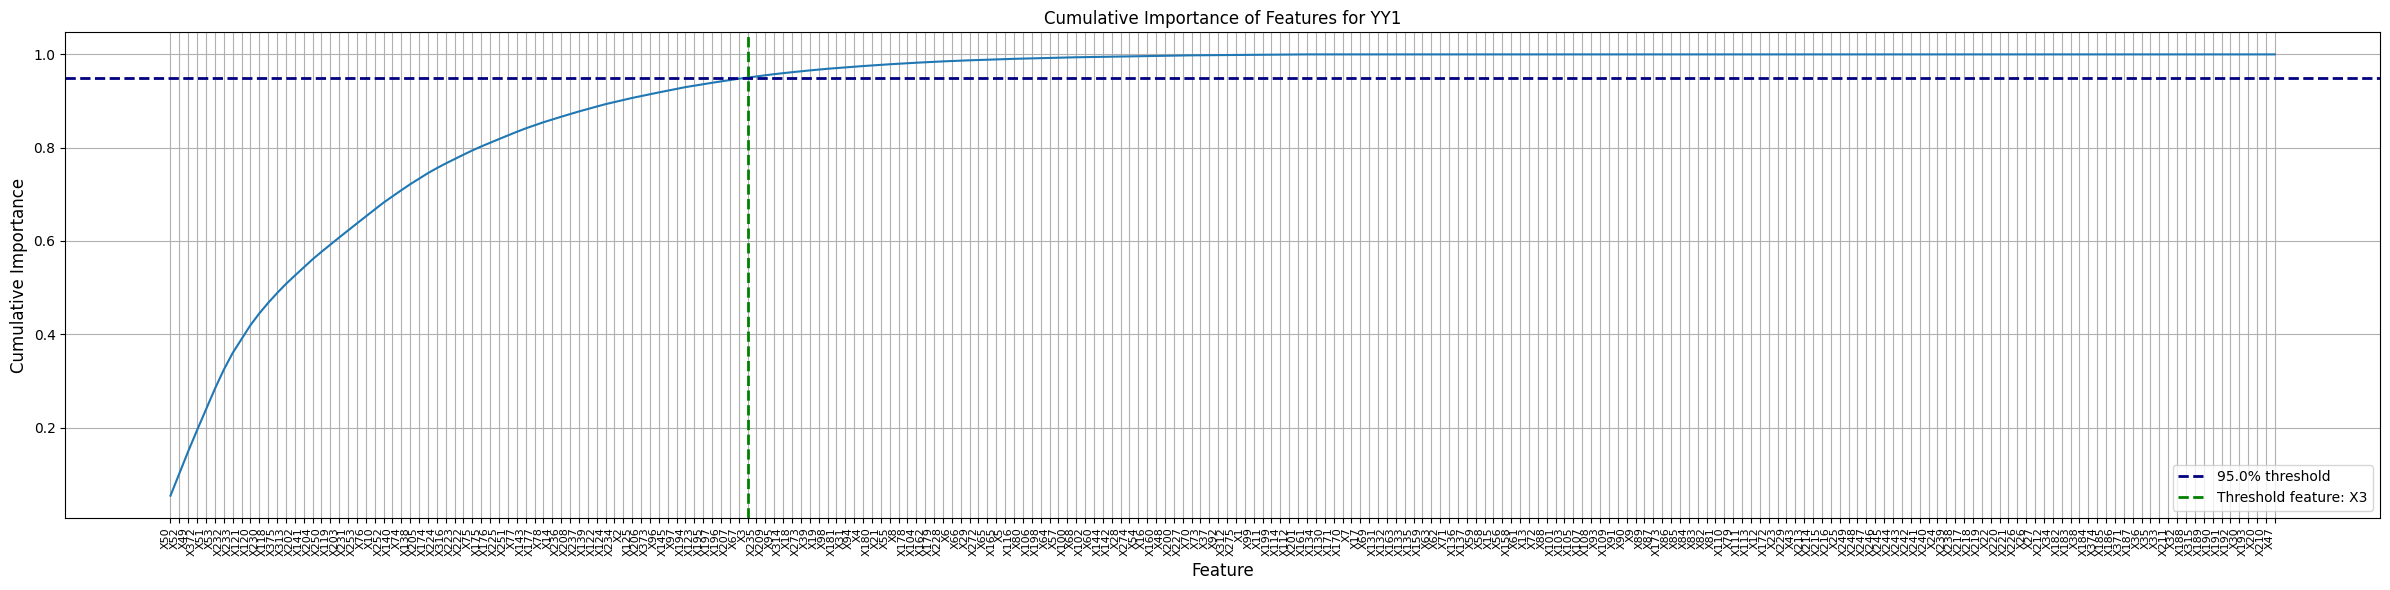

,feature,importance_0,importance_1,average_importance,importance_normalized,cumulative_importance
0,X50,165,159,162.0,0.054000,0.054000
1,X52,142,145,143.5,0.047833,0.101833
2,X49,144,141,142.5,0.047500,0.149333
3,X372,143,129,136.0,0.045333,0.194667
4,X51,132,134,133.0,0.044333,0.239000
5,X53,135,129,132.0,0.044000,0.283000
6,X232,123,122,122.5,0.040833,0.323833
7,X233,110,106,108.0,0.036000,0.359833
8,X121,86,93,89.5,0.029833,0.389667
9,X120,100,78,89.0,0.029667,0.419333


65 parameters are within 95.0% cumulative importance for Y1.
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


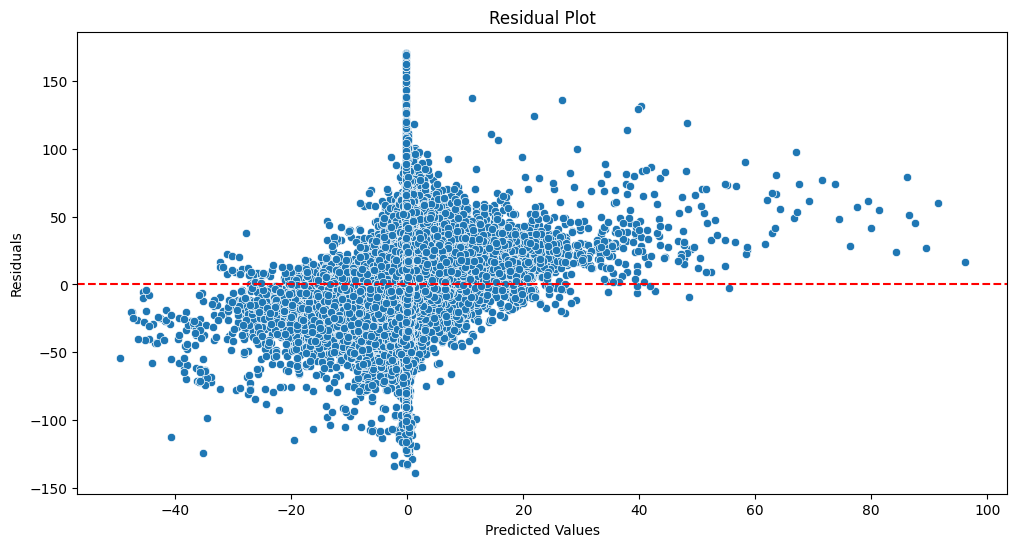

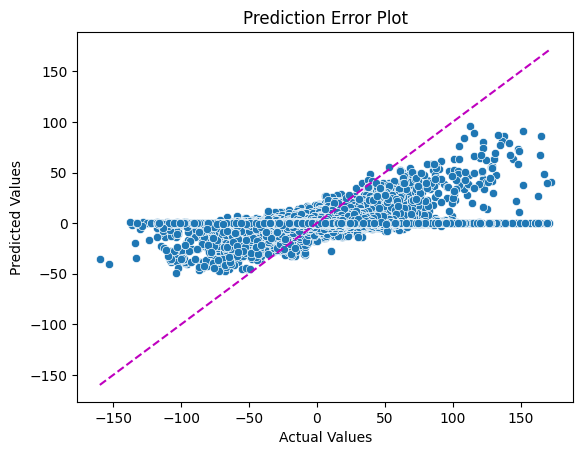

Validation RMSE for Y1: 11.953966831584472
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Training Score 

,time,sym,exch,date,Y2,Q2,X1,X10,X100,X101,...,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:45:01,09:45:01,SPX,cme,2022-01-03,-61.707756,1.00,-1.985130,-0.440099,0.044736,-0.010772,...,0.036888,0.020226,-0.496673,-0.419372,-2.094251,-0.544180,0.947544,-2.114019,-0.783769,-0.229752
2022-01-03 09:45:02,09:45:02,SPX,cme,2022-01-03,-62.025402,1.00,-0.933646,-0.380986,-0.854499,-0.951011,...,-0.852265,-0.910145,-0.657351,-0.689837,-2.004462,-1.462824,-0.014917,-2.296994,-1.078146,-0.137521
2022-01-03 09:45:03,09:45:03,SPX,cme,2022-01-03,-57.324017,1.00,-0.579249,-0.180915,-0.854372,-0.969687,...,-0.842401,-0.919075,-0.350017,-0.383252,-1.690756,-1.482096,-0.056237,-2.001233,-0.784774,0.171525
2022-01-03 09:45:04,09:45:04,SPX,cme,2022-01-03,-58.769417,1.00,-0.658292,-0.028344,-0.044026,-0.496256,...,-0.031957,-0.441668,-0.085383,0.085024,-1.307463,-0.672521,0.405438,-1.738940,-0.313380,0.541654
2022-01-03 09:45:05,09:45:05,SPX,cme,2022-01-03,-59.984489,1.00,-1.331419,-0.100419,0.273158,0.218558,...,0.281678,0.268776,0.342332,0.306470,-1.260183,-0.348818,1.124927,-1.298653,-0.081095,0.575009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 15:59:56,15:59:56,SPX,cme,2023-02-28,-5.074302,0.12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28 15:59:57,15:59:57,SPX,cme,2023-02-28,-4.039149,0.12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28 15:59:58,15:59:58,SPX,cme,2023-02-28,-1.761056,0.12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

,feature,importance_0,importance_1,average_importance
183,X52,136,153,144.5
170,X372,146,122,134.0
182,X51,129,138,133.5
181,X50,129,135,132.0
179,X49,143,117,130.0
123,X232,124,128,126.0
184,X53,108,118,113.0
121,X230,107,117,112.0
124,X233,102,104,103.0
20,X120,98,83,90.5


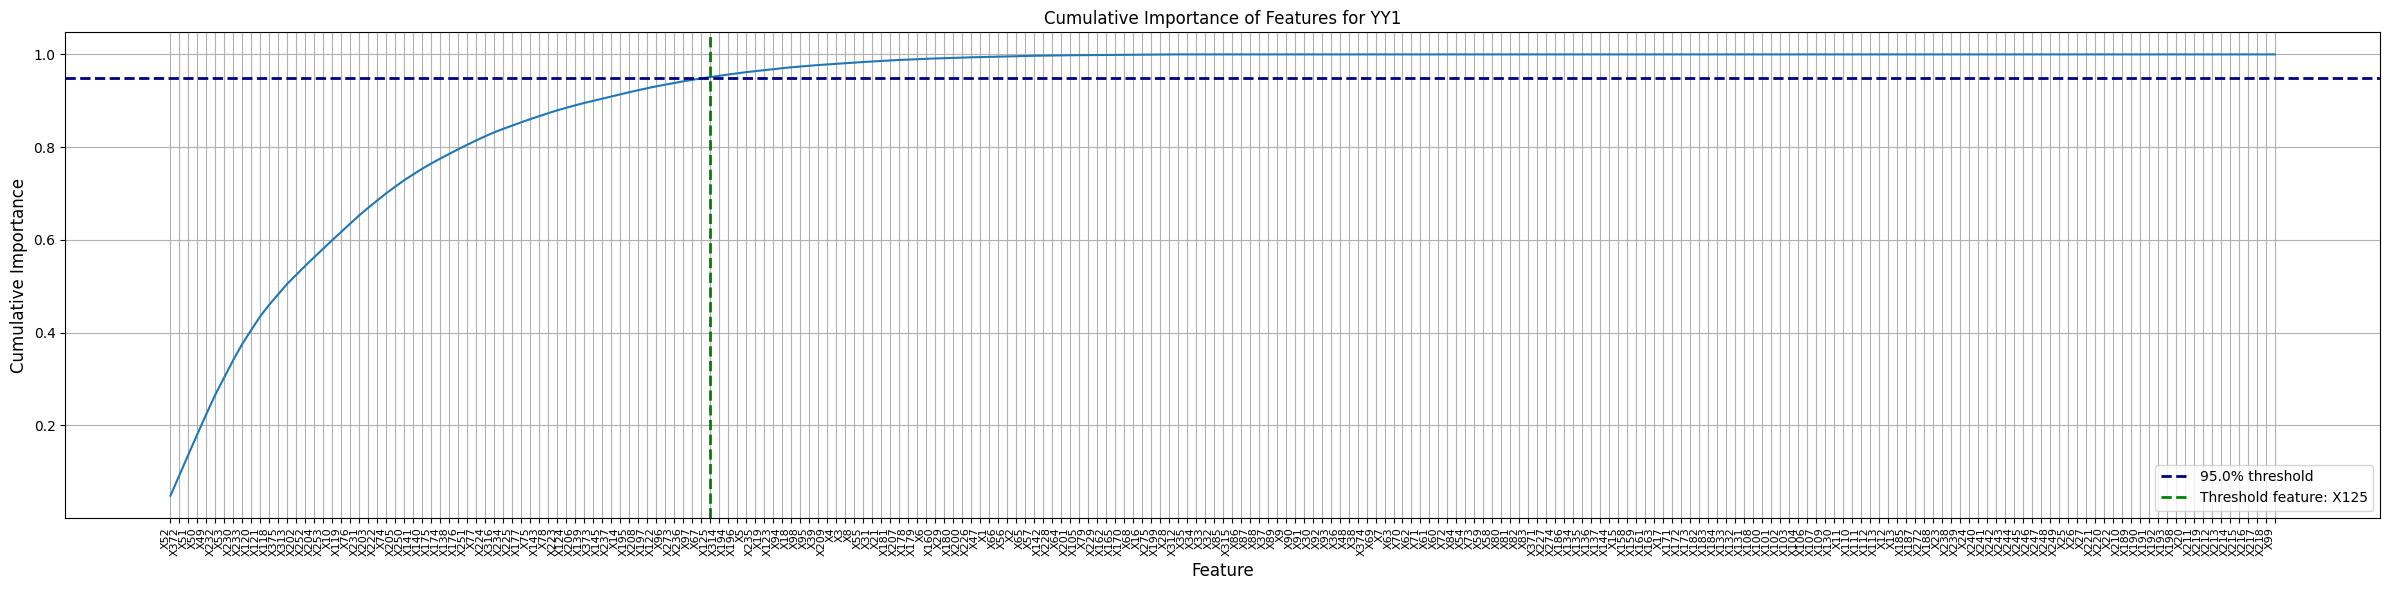

,feature,importance_0,importance_1,average_importance,importance_normalized,cumulative_importance
0,X52,136,153,144.5,0.048167,0.048167
1,X372,146,122,134.0,0.044667,0.092833
2,X51,129,138,133.5,0.044500,0.137333
3,X50,129,135,132.0,0.044000,0.181333
4,X49,143,117,130.0,0.043333,0.224667
5,X232,124,128,126.0,0.042000,0.266667
6,X53,108,118,113.0,0.037667,0.304333
7,X230,107,117,112.0,0.037333,0.341667
8,X233,102,104,103.0,0.034333,0.376000
9,X120,98,83,90.5,0.030167,0.406167


60 parameters are within 95.0% cumulative importance for Y2.
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


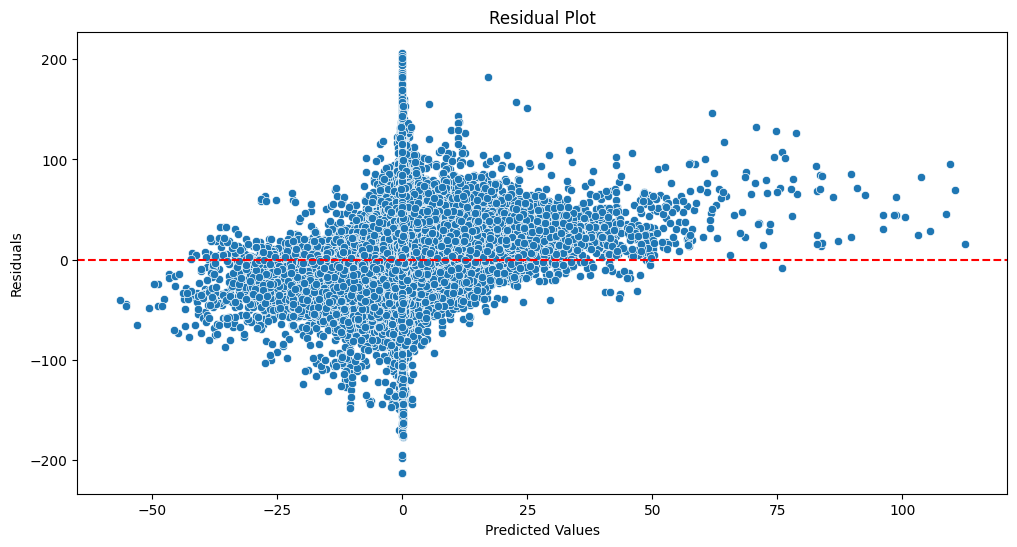

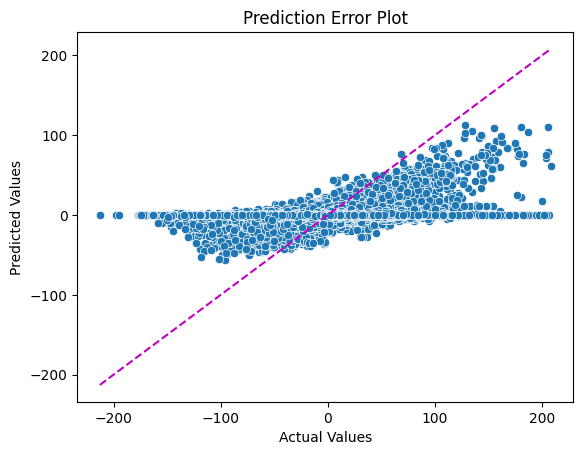

Validation RMSE for Y2: 15.663099271142855
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
Training Score 

In [13]:
def main(y_number, filepath, target_column, threshold=0.95):
    """
    Main function to process data, train model, plot results, and save outputs.
    Args:
    y_number (str): Identifier for the Y target variable.
    filepath (str): Path to the data file.
    target_column (str): Name of the target column.
    threshold (float): Threshold for feature importance.
    """
    # Load and prepare data
    data, X, y = load_and_prepare_data(filepath, [target_column, 'Q'+y_number, 'sym', 'exch','time', 'date'], target_column)

    # Train the model and get feature importances
    feature_importances, model = train_model(X, y, [0, 1], 100)
    
    # Filter out only the numeric columns for importance values before calculating the mean
    importance_columns = [col for col in feature_importances.columns if col.startswith('importance_')]
    feature_importances['average_importance'] = feature_importances[importance_columns].mean(axis=1)
    
    # Save the top 20 features as an image
    top20_features = feature_importances.sort_values('average_importance', ascending=False).head(20)
    display(top20_features)
    save_dataframe_as_image(top20_features, f'Plot n result save/average_importance_y{y_number}.png')
    
    # Plot and save the feature importances
    df, features_to_keep = plot_feature_importances(feature_importances, threshold, 'Y1')
    display(df.head(30))
    save_dataframe_as_image(df.head(30), f'Plot n result save/feature_importance_y{y_number}.png')
    
    # Print the number of important features
    print(f"{len(features_to_keep)} parameters are within {threshold*100}% cumulative importance for Y{y_number}.")
    
    # Model evaluation with residuals and prediction error
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    y_pred = model.predict(X_val)
    plot_residuals(y_val, y_pred)
    
    # Calculate and print RMSE
    rmse = math.sqrt(mean_squared_error(y_val, y_pred))
    print(f"Validation RMSE for Y{y_number}: {rmse}")
    
    # Calculate and print model scores
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    print(f"Training Score for Y{y_number}: {train_score}")
    print(f"Validation Score for Y{y_number}: {val_score}")

    # Identify zero importance features
    zero_importance_features = feature_importances[feature_importances['average_importance'] == 0]['feature'].tolist()
    
    # Create a list of remaining features including 'time' and the target column
    remaining_features = [col for col in X.columns if col not in zero_importance_features] + ['time'] + [target_column]
    
    # Select these columns from the original dataset
    remaining_features_df = data[remaining_features]
    
    # Save the DataFrame with the remaining features
    remaining_features_df.to_pickle(f'Datasave/Q{y_number}_remaining_features.pkl')

    print(f"Removed {len(zero_importance_features)} Zero Importance Features for Y{y_number}:")
    print(zero_importance_features)


if __name__ == "__main__":
    # Set the threshold for cumulative importance
    threshold = 0.95
    
    # Process Y1 data
    print("Y1:")
    main('1', 'Datasave/Q1_filtered2_0.6.pkl', 'Y1', threshold)

    print("\n\nY2:")
    #Uncomment the following line to process Y2 data similarly
    main('2', 'Datasave/Q2_filtered2_0.6.pkl', 'Y2', threshold)